# Imports and Tensorflow memory limiting

In [5]:
%matplotlib inline

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

from keras.models                      import Model
from keras.models                      import Sequential
from keras.layers                      import Convolution2D
from keras.layers                      import BatchNormalization
from keras.layers                      import Activation
from keras.layers                      import Dense
from keras.layers                      import Reshape
from keras.layers                      import UpSampling2D
from keras.layers                      import AveragePooling2D
from keras.layers                      import GlobalAveragePooling2D
from keras.layers                      import Flatten
from keras.optimizers                  import Adam
from keras.preprocessing               import image
from keras.callbacks                   import LearningRateScheduler

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

import tqdm 

In [6]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

limit_mem()

# Image loading

In [27]:
data_path      = '../../data/fractal_zooms_sample_class/'
encoding_size  = 200
model_filename = '../models/model_%06dD.h5' % encoding_size
batch_size     = 48
preprocess     = lambda x: (x - 127.5) / 127.5

In [8]:
image_flow_parameters = {
    'target_size' : (64, 96),
    'color_mode'  : 'grayscale',
    'batch_size'  : batch_size,
    'class_mode'  : None,
}

In [9]:
train_generator = image.ImageDataGenerator(preprocessing_function = preprocess)
train_flow      = train_generator.flow_from_directory(data_path + 'train/', **image_flow_parameters)
test_generator  = image.ImageDataGenerator()
test_flow       = test_generator.flow_from_directory(data_path + 'test/', **image_flow_parameters)

Found 900 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


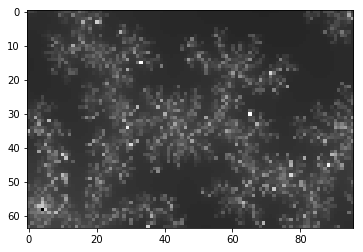

In [10]:
images = next(train_flow)
plt.imshow(images[0].squeeze(), cmap = 'gray')

# Model definition

## Utility functions

In [11]:
def schedule(epoch):
    return np.linspace(1e-3, 1e-5, 100)[epoch]

In [12]:
def convolution2D_init(shape):
    return K.random_normal(shape, stddev = 0.02)

## Encoder definition

In [13]:
encoder = Sequential([
    Convolution2D(64, (3, 3), padding = 'same', kernel_initializer = convolution2D_init, input_shape = (64, 96, 1)),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Convolution2D(128, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Convolution2D(encoding_size, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    GlobalAveragePooling2D(data_format = 'channels_last'),
#     Flatten(),
#     Dense(encoding_size),
#     Activation('tanh')
])

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 96, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 96, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 96, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 96, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 96, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 96, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 96, 64)        36928     
__________

In [14]:
decoder = Sequential([
    # Initial fully connected layer
    Dense(384, input_shape = (encoding_size,)),
    BatchNormalization(),
    Activation('relu'),
    # Reshape into a 16 x 24 array
    Reshape((16, 24, 1)),
    # 16 x 24
    Convolution2D(256, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(256, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    # Upsampling to 32 x 48
    Convolution2D(128, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    # Upsampling to 64 x 96
    Convolution2D(64, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same', kernel_initializer = convolution2D_init),
    BatchNormalization(axis = 1),
    Activation('relu'),
    # final image creation
    Convolution2D(1, (3, 3), padding = 'same', activation = 'tanh', kernel_initializer = convolution2D_init)
])

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 384)               77184     
_________________________________________________________________
batch_normalization_6 (Batch (None, 384)               1536      
_________________________________________________________________
activation_6 (Activation)    (None, 384)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 24, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 24, 256)       2560      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 24, 256)       64        
_________________________________________________________________
activation_7 (Activation)    (None, 16, 24, 256)       0         
__________

In [15]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(optimizer = Adam(), loss = 'mse')

In [16]:
autoencoder_flow = ((x, x) for x in train_flow)

In [17]:
change_lr = LearningRateScheduler(schedule)

In [18]:
autoencoder.fit_generator(autoencoder_flow, epochs = 100, steps_per_epoch = 50, verbose = 2, callbacks = [change_lr]) 

/home/rodgzilla/Documents/machine_learning/keras/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/100
65s - loss: 0.0691
Epoch 2/100
63s - loss: 0.0336
Epoch 3/100
63s - loss: 0.0317
Epoch 4/100
63s - loss: 0.0309
Epoch 5/100
63s - loss: 0.0315
Epoch 6/100
63s - loss: 0.0307
Epoch 7/100
63s - loss: 0.0315
Epoch 8/100
63s - loss: 0.0314
Epoch 9/100
63s - loss: 0.0287
Epoch 10/100
63s - loss: 0.0281
Epoch 11/100
63s - loss: 0.0272
Epoch 12/100
63s - loss: 0.0277
Epoch 13/100
63s - loss: 0.0268
Epoch 14/100
63s - loss: 0.0262
Epoch 15/100
62s - loss: 0.0253
Epoch 16/100
62s - loss: 0.0255
Epoch 17/100
63s - loss: 0.0246
Epoch 18/100
63s - loss: 0.0239
Epoch 19/100
63s - loss: 0.0248
Epoch 20/100
63s - loss: 0.0242
Epoch 21/100
63s - loss: 0.0238
Epoch 22/100
63s - loss: 0.0234
Epoch 23/100
63s - loss: 0.0235
Epoch 24/100
63s - loss: 0.0234
Epoch 25/100
63s - loss: 0.0233
Epoch 26/100
63s - loss: 0.0236
Epoch 27/100
62s - loss: 0.0226
Epoch 28/100
62s - loss: 0.0226
Epoch 29/100
63s - loss: 0.0225
Epoch 30/100
63s - loss: 0.0225
Epoch 31/100
62s - loss: 0.0224
Epoch 32/100
62s 

/home/rodgzilla/Documents/machine_learning/keras/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


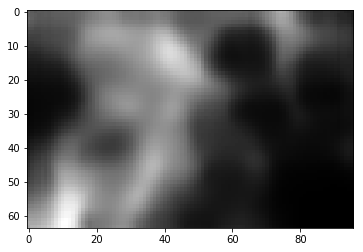

In [19]:
img = images[:1]
plt.imshow(autoencoder.predict(img).squeeze(), cmap = 'gray')

(48, 64, 96, 1) (48, 64, 96, 1)
-0.818825 -1.00565
0.134886 0.00139268
-0.999954 -1.00784
-0.0447155 -0.992218


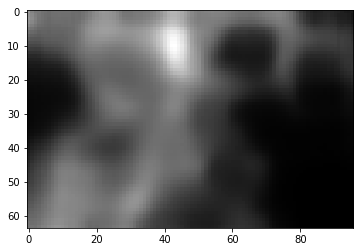

In [20]:
result = autoencoder.predict(images, batch_size = batch_size)
print(result.shape, images.shape)
preproc_images = preprocess(images)
print(result.mean(), preproc_images.mean())
print(result.std(), preproc_images.std())
print(result.min(), preproc_images.min())
print(result.max(), preproc_images.max())

plt.imshow(result[15].squeeze(), cmap = 'gray')

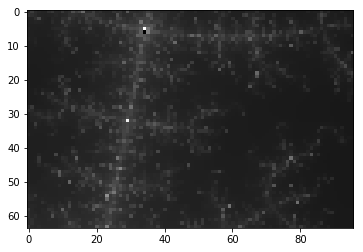

In [21]:
plt.imshow(images[15].squeeze(), cmap = 'gray')

In [28]:
autoencoder.save_weights(model_filename)

In [29]:
autoencoder.load_weights(model_filename)

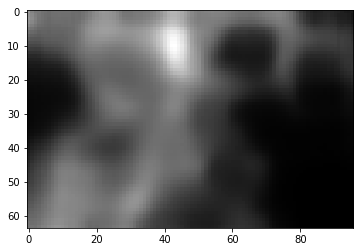

In [30]:
plt.imshow(result[15].squeeze(), cmap = 'gray')